In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Review: Swain v Alabama
What's the probability of getting the actual panel with 8/100 black jurors?

Steps:
1. Start with the distributions of eligible jurors and the actual panel
2. Draw panels at random from the eligible jurors
3. See if actual panel is likely

### Step 1: Distributions of population and sample

In [2]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


### Step 2: Draw panels at random from population

In [3]:
population_distribution = swain.column('Eligible')
panel_size = 100

def random_jury_panel():
    panel = swain.select(0).sample(panel_size, weights=swain.column('Eligible'))
    counts = panel.group(0)
    sample_proportions = counts.select(0).with_column('Random', counts.column(1) / panel_size)
    sample_proportions.set_format(1, PercentFormatter(0))
    return swain.join('Ethnicity', sample_proportions)

random_jury_panel()

Ethnicity,Eligible,Panel,Random
Black,26%,8%,21%
Other,74%,92%,79%


A quicker way of doing this is to use `sample_proportions` function:

In [4]:
population_distribution = swain.column('Eligible')
panel_size = 100

def randomPanelQuicker():  
    return swain.with_column(
    'Random', 
    sample_proportions(100, population_distribution)).set_format(
        'Random', PercentFormatter(0))

randomPanelQuicker()

Ethnicity,Eligible,Panel,Random
Black,26%,8%,22%
Other,74%,92%,78%


### Step 3: See if sample panel is unlikely

In [5]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

In [6]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = randomPanelQuicker()
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & random samples', tvds)
results

TVD between the population & random samples
0.01
0.03
0.01
0.01
0.04
0.05
0.04
0.02
0.05
0.09


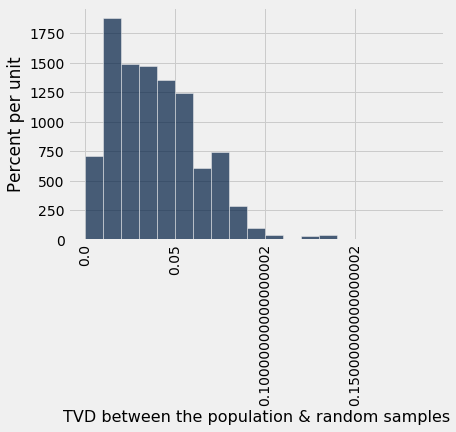

In [7]:
results.hist(bins=np.arange(0, 0.2, 0.01))

Compare the histogram above with the TVD that we obtained from between the eligible population and actual panel (0.18), marked below with the red dot.

NameError: name 'plots' is not defined

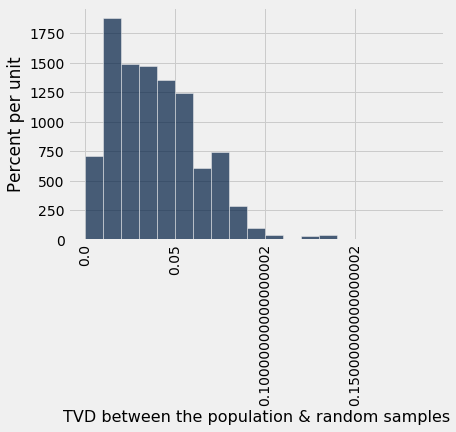

In [8]:
results.hist(bins=np.arange(0, 0.2, 0.01))
plots.scatter(0.18, 0, color='red', s=30);

We can see that 0.18 is far on the right side, which shows that the actual panel is unlikely to be drawn at random from eligible jurors. 

# Empirical Distribution

## Distribution of a Statistic
* **Statistic**: a quantity computed for a particular sample
* **Distribution**: The chance of each outcome of sampling
* **Sampling distribution**: Chance of each value of a statistic (computed from all possible samples)
    * Also know as **probability distribution of the statistic**
* **Empirical distribution**: Observations of a statistic (computed from some samples drawn at random)

## Alameda County Jury Panels
* **Statistic**: TVD between a sample and the population distribution
* **Distribution**: The chance of each possible TVD
* **Sampling distribution**: Exact probability of each TVD
* **Empirical distribution**: Probability of each TVD using simulated panels from the population

# Multiple Categories
We have developed a way of assessing models about chance processes that generate data in 2 categories. We can actually extend this method to models involving data in multiple categories. The process of assessment is the same as before, the difference is that **we need to come up with a new statistic to simulate**.

## Jury Selection in Alameda County
In 2010, ACLU (American Civil Liberties Union) of Northern California presented a [report](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) regarding jury selection in Alameda County, California. The report concluded that certain ethnic groups are underrepresented among jury panelist in Alameda County, and suggested some reforms of the process by which eligible jurors are assigned to panels. In this section, we'll perform our own analysis of the data and examine some questions that arise as a result.

## Jury Panels
A jury panel is **a group of people chosen to be prospective jurors**. The final trial jury is selected from among them. Jury panels can consist of a few dozen people or several thousand, depending on the trial. By law, a jury panel is supposed to be representative of the community in which the trial is taking place. 

Section 197 of California’s Code of Civil Procedure says, “All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court.”

The final jury is selected from the panel by deliberate inclusion or exclusion. 
* The law allows potential jurors to be excused for medical reasons
* Lawyers on both sides may strike a certain number of potential jurors from the list in "peremptory challenges"
* The trial judge might make a selection based on questionnaires filled out by the panel

However, the initial panel is supposed to resemble a random sample of the population of eligible jurors.

## Composition of Panels in Alameda County
Focus of the study: the ethnic composition of jury panels in Alameda County.
The ACLU compiled data on the ethnic composition of the jury panels in 11 felony trials in Alameda County in the years 2009 and 2010. In those panels, the total number of people who reported for jury service was 1,453. The ACLU gathered demographic data on all of these prospective jurors and compared those data with the composition of all eligible jurors in the county.

The data are compiled in the table `jury` below. 

In [ ]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

jury

A bar chart is helpful for visualizing the differences.

In [ ]:
jury.barh('Ethnicity')

### Comparison with Panels Selected at Random
What if we select a random sample of 1,453 people from the population of eligible jurors? Will the distribution of the ethnicities look like the distribution of the panels above?

We can solve this using `sample_proportions` method and augmenting the `jury` table with a column of the proportions in our sample.

**NOTE:** Random sample of prospective jurors are selected **without replacement**. However, when the size of a sample is small relative to the size of the population, sampling without replacement resembles sampling with replacement (the proportions in the population won't change much with each sample draw). The population of eligible jurors in Alameda County is over a million; compared to that, a sample size of 1,500 is small. Thus, we will sample with replacement!

In the cell below, we sample at random 1,453 times from the distribution of eligible jurors and display the distribution of the random sample along with the distributions of the eligible jurors and the panel in the data.

In [ ]:
eligible_population = jury.column('Eligible')
sample_distribution = sample_proportions(1453, eligible_population)
panels_and_sample = jury.with_column('Random Sample', sample_distribution)
panels_and_sample

The distribution of the random sample is close to the distribution of the eligible population, but not to the distribution of the panels.

In [ ]:
panels_and_sample.barh('Ethnicity')

To assess whether this observation is particular to one random sample or more general, we can simulate multiple panels under the model of random selection and see what the simulations predict. But we won’t be able to look at thousands of bar charts like the one above. We need a statistic that will help us assess whether or not the model or random selection is supported by the data.

## New Statistic: The Distance between 2 Distribution
The differences between 2 numbers `x` and `y` is `| x - y |`. However, in this case we need to quantify the distance between 2 distributions: the blue and gold distribution below.

In [ ]:
jury.barh('Ethnicity')

For this, we'll compute a quantity called the **total variation distance** between 2 distributions. The calculation is an extension to the calculation of distance between 2 numbers.

We first take the difference between the 2 proportions in each category.

In [ ]:
# Augment the table with a column of differences between proportions

jury_with_diffs = jury.with_column(
    'Difference', jury.column('Panels') - jury.column('Eligible')
)
jury_with_diffs

Notice that on the **Difference** column, the sum is 0. The positive entries cancel out the negative entries. This is numerical evidence that in the bar chart, the gold bars exceeds the blue bars by exactly as much as the blue bars exceed the gold. The proportions in each of the 2 columns **Panels** and **Eligible** add up to 1, and so the give-and-take between their entries must add up to 0.

To avoid cancellation, we take the absolute values and then sum all the entries; however, this would give us twice the total of the positive entries. Therefore, divide the sum by 2.

In [ ]:
jury_with_diffs = jury_with_diffs.with_column(
    'Absolute Difference', np.abs(jury_with_diffs.column('Difference'))
)

jury_with_diffs

In [ ]:
jury_with_diffs.column('Absolute Difference').sum()/2

The `0.14` above is the total variation distance (TVD) between the distribution of ethnicities in the eligible juror population and the distribution in the panels.

## Simulating One Value of the Statistic
We can use TVD between distributions as the statistic to simulate. This **helps determining whether the model of random selection is good**, because large values of the distance will be evidence against the model.

Since we're going to compute TVD repeatedly, we'll write a function to compute it.

The function total_variation_distance returns the TVD between distributions in two arrays.

In [ ]:
def total_variation_distance(distribution_1, distribution_2):
    return sum(np.abs(distribution_1 - distribution_2)) / 2

`total_variation_distance` helps calculate the statistic in each repetition of the simulation.

In [ ]:
total_variation_distance(jury.column('Panels'), jury.column('Eligible'))

Now we use `total_variation_distance` to calculate the TVD between the distributions of eligible jurors and one random sample. The code below simulates one value of our statistic. Recall that `eligible_population` is an array containing the distribution of our eligible jurors.

In [ ]:
sample_distribution = sample_proportions(1453, eligible_population)
total_variation_distance(sample_distribution, eligible_population)

Notice above that the distance is smaller than 0.14! 

## Predicting the Statistic Under the Model of Random Selection
The **TVD between the distributions of the random sample and the eligible jurors** is the statistic that we use to measure the distance between the 2 distributions. By repeating the process of sampling, we can see how much the statistic varies with different random samples.

The code below simulates the statistic based on multiple replications of the random sampling process.

In [ ]:
# Simulate TVD between
# distribution of random samples
# and distribution of eligible population

eligible_population = jury.column('Eligible')
panel_size = 1453

tvds = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    sample_distribution = sample_proportions(panel_size, eligible_population)
    new_tvd = total_variation_distance(sample_distribution, eligible_population)
    tvds = np.append(tvds, new_tvd)

# Create a table out of the sampling procedure above
results = Table().with_columns('TVD between population and random sample', tvds)
results

In [ ]:
results.hist(bins=np.arange(0, 0.1, 0.01))
plots.scatter(0.14, 0, color='red', s=30);

From the empirical histogram above, we see that drawing 1,453 jurors at random from the pool of eligible candidates gives out a distribution that deviates from the eligible jurors' distribution by less than 0.05. The TVD of 0.14 is far right of the histogram!

As a side note, we can simulate what the histogram looks like if we vary the amount of TVDs we take.

In [ ]:
def hist_n_samples(tbl, n, bins=None):
    '''Draws histogram of first n rows of first column in tbl.'''
    tbl.take(np.arange(n)).hist(bins=bins)
    plt.ylim(0, 50)
    plt.show()

In [ ]:
_ = interact(hist_n_samples, tbl=fixed(results), n=(1, 1000, 10), bins=fixed(np.arange(0, 0.2, 0.01)))

Above, as we increase `n` (the TVDs), the histogram resembles more of that of the TVD between the eligible population and the sample population.

### Assess the Model of Random Selection
The panels in the study, however, were not quite so similiar to the eligible population. The TVD between the panels and the population was 0.14, which is far out of the histogram above.

The data in the panels is not consistent with the predicted values of the statistic based on the model of random selection. Therefore, our analysis supports ACLU's calculation that the panels were not representative of the distribution provided for the eligible jurors.

### Possible Explanations for Differences
Our analysis does not say **why** the distributions are different or what the difference might imply.

The ACLU report discusses several possible reasons for the discrepancies. For example, **some minority groups were underrepresented on the records of voter registration and of the DMV, the 2 main sources from which jurors are selected**. At the time of the study, the county didn't have an effective process for following up on prospective jurors who had been called but had failed to appear. ACLU listed several other reasons as well. But regardless the reasons, the composition of the jury panels was different from what we would have expected in a random sample from the distribution in the `Eligible` column.

### Questions about Data
We have developed a powerful technique that helps decide whether a distribution looks like a random sample from another. However, data science is more than just the techniques; it involves thoughtful examination of how the data were gathered.

#### Eligible Jurors
**Not everyone is eligible to serve on jury**. On the [website](http://www.alameda.courts.ca.gov/pages.aspx/jury-duty-overview), the Superior Court of Alameda County says that one may be called to serve if:
* At least 18 years old
* U.S. Citizen and a resident of the county or district where summoned
* Able to understand English
* Physically and mentally capable of serving
* Must not have served as any kind of juror in the past 12 months
* Not have been convicted of a felony

The census doesn't maintain records of the population in all these categories. The ACLU had to obtain the demographics of eligible jurors in some other way. Here's the description of the process they followed and the flaws that it might contain:

“For the purpose of determining the demographics of Alameda County’s jury eligible population, we used a declaration that was prepared for the Alameda County trial of People v. Stuart Alexander in 2002. In the declaration, Professor Weeks, a demographer at San Diego State University, estimated the jury eligible population for Alameda County, using the 2000 Census data. To arrive at this estimate, Professor Weeks took into account the number of people who are not eligible for jury services because they do not speak English, are not citizens, are under 18, or have a felony conviction. Thus, his estimate should be an accurate assessment of who is actually eligible for jury service in Alameda County, much more so than simply reviewing the Census report of the race and ethnicity of all people living in Alameda County. It should be noted, however, that the Census data on which Professor Weeks relied is now ten years old and the demographics of the county may have changed by 2 or 3 percent in some categories.”

From above, the distribution of ethnicities of eligible jurors used in the analysis is itself an estimate and might be somewhat out of date.

#### Panels
In addition, panels aren't selected from the entire eligible population. The Superior Court of Alameda County says, “The objective of the court is to provide an accurate cross-section of the county’s population. The names of jurors are selected at random from everyone who is **a registered voter and/or has a driver’s license or identification card issued by the Department of Motor Vehicles**.”

All these raises question about how to accurately estimate the ethnic composition of eligible jurors in Alameda Country

* It isn't clear how the 1453 panelists were classified into the different ethnic categories (the ACLU report says that “attorneys … cooperated in collecting jury pool data”). 
    * There are serious social, cultural, and political factors that affect who gets classified or self-classifies into each ethnic category. 
* We also don’t know whether the definitions of those categories in the panels are the same as those used by Professor Weeks who in turn used Census categories in his estimation process. 
* There are also questions about the correlation between the 2 distributions being compared.

Thus, while we have a clear conclusion about the data in our table – the panels do not look like a random sample from the distribution provided for eligible jurors – questions about the nature of the data prevent us from concluding anything broader.

### Discussion: How does the analysis change if the jury panels had only 50 people instead of 1453?

In [ ]:
panel_size = 50
repetitions = 1000
tvds = make_array()

for i in np.arange(repetitions):
    sample_distribution = sample_proportions(panel_size, eligible_population)
    new_tvd = total_variation_distance(sample_distribution, eligible_population)
    tvds = np.append(tvds, new_tvd)

results_50 = Table().with_columns('TVD between population and random sample', tvds)
results_50

In [ ]:
_ = interact(hist_n_samples, tbl=fixed(results_50), n=(1, 1000, 10), bins=fixed(np.arange(0, 0.2, 0.01)))

Above, the histogram look more distributed than the histogram with 1453 panels. **As sample size gets smaller, the more the chances that you'll get a sample that looks different than the original population**.

* The more the sample resembles the population, the lower the TVD
* and vice versa.

# Decisions and Uncertainty
We've seen some examples of assessing models that involve chance, by comparing observed data to the predictions made by the model. In those examples, it is clear about whether the data were consistent with the model's predictions The data were either far away from the predictions, or very close to them.

However, the result are not always clear.
* How far is "far"?
* How close is "close"?

While these questions don’t have universal answers, there are guidelines and conventions that you can follow. In this section we will describe some of them.

But first let's develop a general framework of decision making, into which all our examples will fit.

What we've developed while assessing models are some of the fundamental concepts of **statistical tests of hypotheses**. Using statistical tests as a way of making decision is standard in many fields and has a standard terminology. Here are the steps for statistical tests:

### Step 1: Hypotheses
All statistical tests attempts to choose between 2 views of the world. Specifically, the choice is between 2 views about how the data were generated. These 2 views are **hypotheses**.

#### The Null Hypothesis
This hypothesis says that data were generated at random under clearly specified assumptions about the randomness. The word **null** reinforces the idea that if the data look different from what the null hypothesis predicts, the difference is due to **nothing but chance**.

From a practical perspective, the null hypothesis is **a hypothesis under which you can simulate data**.

#### The Alternative Hypothesis
This hypothesis says that some reason other than chance made the data differ from the predictions of the model in the null hypothesis.

### Step 2: The Test Statistic
To decide between the 2 hypothesis, we need to choose a statistic that we can use to make the decision. This statistic is called the **test statistic**.

To see how to make the choice in general, analyze the alternative hypothesis. What values of the statistic will make you think that the alternative hypothesis is a better choice than the null?
* If the answer is either "big values" or "small values", you might have a good choice of statistic
* If the answer is "both big values and small values", you should look again at your statistic and see if taking an absolute value can change the answer to just "big values"

The **observed value of the statistic** is the value of the statistic you get from the data in the study, not a simulated value.

### Step 3: The Distribution of the Test Statistic, Under the Null Hypothesis
The main computational aspect of a test of hypothesis is figuring out **what the values of the test statistic might be if the null hypothesis were true**.

The test statistic is simulated based on the assumptions of the model in the null hypothesis. The model involves chance, so the statistic comes out differently when simulated multiple times.

By simulating the statistic repeatedly, we get a good sense of its possible values and which ones are more likely than others. In other words, we get good approximation to the probability distribution of the statistic, as predicted by the model in the null hypothesis.

As with all distributions, it is very useful to visualize the distribution using histogram.

### Step 4: The Conclusion of the Test
The choice between the null and alternative hypotheses depends on the comparison between what you computed in Steps 2 and 3: **the observed value of the test statistic and its distribution as predicted by the null hypothesis**.

If the 2 are consistent with each other, then the observed test statistic is in line with what the null hypothesis predicts. In other words, the test doesn't point towards the alternative hypothesis; the null hypothesis is better supported by the data. 

But if the 2 are not consistent with each other (as in the case with Alameda County jury panels), then the data don't support the null hypothesis. That's why we concluded that the jury panels were not selected at random. Something other than chance affected the composition. 

If the data don't support the null hypothesis, we say that **the test rejects the null hypothesis**.

#### The Meaning of "Consistent"
In the Alameda County juries example, it is clear that the observed test statistic was far from what was predicted by the null hypothesis. 




# Hypothesis Testing (Video Lectures)
### Step 1: The Hypotheses
* A test chooses between 2 views of how data were generated
* **Null hypothesis** proposes that data were generated at random
* **Alternative hypothesis** proposes some cause other than chance

### Step 2: The Test Statistic
* A value that can be computed for the data and for samples

### Step 3: The Sampling Distribution of the Test Statistic
* What the test statistic might be if the null hypothesis were true
* Approximate the sampling distribution by an empirical distribution

# Alameda County Hypothesis Test
### Step 1: The Hypotheses
* **Null hypothesis**: The panel of jurors was selected at random from the eligible juror population. Any differences between the ethnicity distributions of panel and population are due to change.
* **Alternative hypothesis**: The panel was not selected at random

### Step 2: The Test Statistic : TVD between a panel and the population distribution

### Step 3: The Sampling Distribution of the Test Statistic
Simulate drawing panels from population. See if actual panel TVD is likely
